In [209]:
import os
import pandas as pd
import numpy as np
import time

main_publisher = 'Merged'

script_dir = os.path.dirname(os.path.realpath('__file__'))
path = os.path.join(script_dir, '../Data/' + main_publisher + '/')

df_chapters = pd.read_csv(path + 'chapters.csv', delimiter = '|')
df_chapters_embeddings = pd.read_csv(path + 'embeddings_chapters.csv', delimiter = '|', index_col=0)
df_concepts = pd.read_csv(path + 'concepts_bis.csv', delimiter = '|')
df_concepts_embeddings = pd.read_csv(path + 'embeddings_concepts_bis.csv', delimiter = '|', index_col=0)
df_classes = pd.read_csv(path + 'classes_bis.csv', delimiter = '|')
df_classes_embeddings = pd.read_csv(path + 'embeddings_classes_bis.csv', delimiter = '|', index_col=0)
df_precedences_episodes = pd.read_csv(path + 'precedences_episodes.csv', delimiter = '|')
df_precedences_series = pd.read_csv(path + 'precedences_series.csv', delimiter = '|')

df_concepts['Concept'] = df_concepts['Concept'].apply(lambda x : x.split('/')[-1])

df_classes = df_classes.dropna()
print(f'{df_chapters["Cid"].isna().sum().sum():04d} NaN values in chapters.')
print(f'{df_concepts.isna().sum().sum():04d} Nan values in concepts.')
print(f'{df_classes.isna().sum().sum():04d} Nan values in classes.')
print(f'{df_precedences_episodes.isna().sum().sum():04d} Nan values in episdes precedences.')
print(f'{df_precedences_series.isna().sum().sum():04d} Nan values in series precedences.')

0000 NaN values in chapters.
0000 Nan values in concepts.
0000 Nan values in classes.
0000 Nan values in episdes precedences.
0000 Nan values in series precedences.


In [210]:
from utils import *

unique_oer_id = id_mapper(df_chapters['Cid'], 'OER')
unique_concept_id =  id_mapper(df_concepts['Concept'], 'Concept')
unique_class_id =  id_mapper(df_classes['Class'], 'Class')

In [211]:
oer_covers_concept_subject = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'mappedID', 
                                       how = 'left', right_on = 'OER')
oer_covers_concept_pr = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'PR', 
                                          how = 'right', right_on = 'OER')
oer_covers_concept_object = edge_construction(df1 = df_concepts, df2 = unique_concept_id, col = 'mappedID', 
                                       how = 'left', right_on = 'Concept')

oer_before_oer_ep_subject = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_ep_object = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')
oer_before_oer_sr_subject = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_sr_object = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')

concept_belongs_class_subject = edge_construction(df1 = df_classes, df2 = unique_concept_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Concept', right_on = 'Concept')
concept_belongs_class_object = edge_construction(df1 = df_classes, df2 = unique_class_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Class', right_on = 'Class')

oer_covers_concept = torch.stack([oer_covers_concept_subject, oer_covers_concept_object], dim = 0).long()
oer_covers_concept_rev = torch.stack([oer_covers_concept_object, oer_covers_concept_subject], dim = 0).long()
oer_before_oer_ep = torch.stack([oer_before_oer_ep_subject, oer_before_oer_ep_object], dim = 0).long()
oer_before_oer_sr = torch.stack([oer_before_oer_sr_subject, oer_before_oer_sr_object], dim = 0).long()
concept_belongs_class = torch.stack([concept_belongs_class_subject, concept_belongs_class_object], dim = 0).long()
concept_belongs_class_rev = torch.stack([concept_belongs_class_object, concept_belongs_class_subject], dim = 0).long()
print(oer_covers_concept.shape)
print(oer_covers_concept_rev.shape)
print(oer_before_oer_ep.shape)
print(oer_before_oer_sr.shape)
print(concept_belongs_class.shape)
print(concept_belongs_class_rev.shape)

torch.Size([2, 24347])
torch.Size([2, 24347])
torch.Size([2, 2928])
torch.Size([2, 1407])
torch.Size([2, 72048])
torch.Size([2, 72048])


In [212]:
chapters_embeddings_tmp = {}
concepts_embeddings_tmp = {}
classes_embeddings_tmp = {}

chapters_r = range(len(df_chapters['Cid'].unique()))
concepts_c = range(len(df_concepts['Concept'].unique()))
classes_c = range(len(df_classes['Class'].unique()))

chapters_embeddings = np.zeros(shape=(len(chapters_r), 768))
concepts_embeddings = np.zeros(shape=(len(concepts_c), 768))
classes_embeddings = np.zeros(shape=(len(classes_c), 768))


i = 0
for r in chapters_r:
    chapters_embeddings_tmp[r] = list(filter(None, df_chapters_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    chapters_embeddings_tmp[r] = [float(f) for f in chapters_embeddings_tmp[r]]
    for a in range(len(chapters_embeddings_tmp[r])):
            chapters_embeddings[i][a] = chapters_embeddings_tmp[r][a]
    i += 1

i = 0
for r in concepts_c:
    concepts_embeddings_tmp[r] = list(filter(None, df_concepts_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    concepts_embeddings_tmp[r] = [float(f) for f in concepts_embeddings_tmp[r]]
    for a in range(len(concepts_embeddings_tmp[r])):
            concepts_embeddings[i][a] = concepts_embeddings_tmp[r][a]
    i += 1   

i = 0
for r in classes_c:
    classes_embeddings_tmp[r] = list(filter(None, df_classes_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    classes_embeddings_tmp[r] = [float(f) for f in classes_embeddings_tmp[r]]
    for a in range(len(classes_embeddings_tmp[r])):
            classes_embeddings[i][a] = classes_embeddings_tmp[r][a]
    i += 1

chapters_embeddings = torch.from_numpy(chapters_embeddings).to(torch.float32)
concepts_embeddings = torch.from_numpy(concepts_embeddings).to(torch.float32)
classes_embeddings = torch.from_numpy(classes_embeddings).to(torch.float32)

In [213]:
import random

def seed_everything(seed=0):                                                  
       random.seed(seed)                                                            
       torch.manual_seed(seed)                                                      
       torch.cuda.manual_seed_all(seed)                                             
       np.random.seed(seed)                                                         
       os.environ['PYTHONHASHSEED'] = str(seed)                                     
       torch.backends.cudnn.deterministic = True                                    
       torch.backends.cudnn.benchmark = False

In [214]:
hidden_channels_selected = 16
entity_features = 768
num_layers_selected = 6
epochs_selected = 300 #300 the best
learning_rates_selected = 0.01

selected_params = [{
    'epochs': epochs_selected, 
    'hidden_channels': hidden_channels_selected, 
    'num_layers': num_layers_selected, #8 is too much => generated NaN values in node attributes
    'lr': learning_rates_selected, 
    'entity_features': entity_features
}]

In [215]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
data['OER'].x = chapters_embeddings
data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
data['Concept'].x = concepts_embeddings
data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
data['Concept', 'rev_covers', 'OER'].edge_index = oer_covers_concept_rev

data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_pr
print(oer_before_oer_ep.shape)
data['OER', 'before_sr', 'OER'].edge_index = oer_before_oer_sr
data['OER', 'before_ep', 'OER'].edge_index = oer_before_oer_ep

#data = T.ToUndirected()(data)
data.validate()
print(data)

torch.Size([2, 2928])
HeteroData(
  OER={
    node_id=[4407],
    x=[4407, 768]
  },
  Concept={
    node_id=[7970],
    x=[7970, 768]
  },
  (OER, covers, Concept)={
    edge_index=[2, 24347],
    edge_attr=[24732]
  },
  (Concept, rev_covers, OER)={ edge_index=[2, 24347] },
  (OER, before_sr, OER)={ edge_index=[2, 1407] },
  (OER, before_ep, OER)={ edge_index=[2, 2928] }
)


In [216]:
agnostic = False
if agnostic:
    num_val = 0.5
    num_test = 0.5
else:
    num_val = 0.1
    num_test = 0.1
seed_everything()
transform = T.RandomLinkSplit(
    num_val = num_val,
    num_test = num_test,
    disjoint_train_ratio = 0.0,
    neg_sampling_ratio = 0.8,
    add_negative_train_samples = True,
    edge_types=('OER', 'before_sr', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for testing')
print(train_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(train_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[1][:5])

2028	 Edges for training
252	 Edges for validation
252	 Edges for testing
tensor([1247, 2703, 4364, 4040, 3726])
tensor([1706,  134, 2279, 3486, 3509])
tensor([3269, 2685,  776, 3197, 2997])
tensor([1248, 2704, 4365, 4041, 3727])
tensor([1707,  135, 2280, 3487, 3510])
tensor([3270, 2686,  777, 3198, 2998])


In [217]:
seed_everything()
cross_val_data = {}
cross_val_data["OER", "before_sr", "OER"] = {}
print(len(train_data["OER", "before_sr", "OER"].edge_label_index[0]) + 
      len(val_data["OER", "before_sr", "OER"].edge_label_index[0]) +
      len(test_data["OER", "before_sr", "OER"].edge_label_index[0]))

cross_val_data["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label, 
     val_data["OER", "before_sr", "OER"].edge_label,
     test_data["OER", "before_sr", "OER"].edge_label], 
    dim = 0).long()
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label_index, 
     val_data["OER", "before_sr", "OER"].edge_label_index,
     test_data["OER", "before_sr", "OER"].edge_label_index], 
    dim = 1).long()
cross_val_data["OER", "before_sr", "OER"]["edge_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_index, 
     val_data["OER", "before_sr", "OER"].edge_index,
     test_data["OER", "before_sr", "OER"].edge_index],
    dim = 1).long()
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_index"][0]))

2532
2532
2532
3521


In [218]:
seed_everything()
num_samples = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
shuffled_index = np.arange(num_samples)
np.random.shuffle(shuffled_index)
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][shuffled_index]

In [219]:
cv = 5
chunk_size = int(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]) / cv)
cross_val_chunks = []
for n in range(cv):
    cross_val_chunk = {}
    cross_val_chunk["OER", "before_sr", "OER"] = {}
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = {}
    begin = n * chunk_size
    if n == cv - 1:
        end = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
    else :
        end = (n+1) * chunk_size
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][begin : end]
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][begin : end])
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][begin : end])
    cross_val_chunks.append(cross_val_chunk)

In [220]:
cross_val_data_train = []
cross_val_data_test = []
for n in range(cv) :
    cross_val_data_train_chunk = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label"], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label"]
     ], 
    dim = 0).long()
    cross_val_data_test_chunk = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label"]

    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0]
     ], 
    dim = 0).long())
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1]
     ], 
    dim = 0).long())
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][0])
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][1])
    
    cross_val_data_train.append(cross_val_data_train_chunk)
    cross_val_data_test.append(cross_val_data_test_chunk)

len(cross_val_data_train)

5

In [221]:
def train(model, train_data, epochs, lr, verbose = False):
    total_loss = 0
    loss_values = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    duration = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        ground_truth = train_data["OER", "before_sr", "OER"].edge_label
        assert pred.shape == ground_truth.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({pred.shape, ground_truth.shape})'
        loss = F.binary_cross_entropy_with_logits(pred.float(), ground_truth.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
        loss_values.append(loss.item())
        if verbose and epoch % 10 == 0:
            print(f"Epoch : {epoch:03d}, Loss : {total_loss : .4f}")
    duration = time.time() - duration
    
    return {
        'Loss_values' : loss_values,
        'Loss' : total_loss,
        'Duration' : duration,
        'Model' : model
    }
def predict(model, test_data):

    preds = model(test_data).detach().numpy()
    preds_labels = (preds > 0.5) * 1
    ground_truths = test_data["OER", "before_sr", "OER"].edge_label
    assert preds.shape == ground_truths.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({preds.shape, ground_truths.shape})'
    #auc_score = roc_auc_score(ground_truths, preds)
    precision = precision_score(ground_truths, preds_labels, zero_division = np.nan)
    accuracy = accuracy_score(ground_truths, preds_labels)
    f1 = f1_score(ground_truths, preds_labels, average='macro')
    recall = recall_score(ground_truths, preds_labels, average='macro')
    return {
        #'AUC' : auc_score,
        'Precision' : precision,
        'Accuracy' : accuracy,
        'Recall' : recall,
        'F1' : f1
    }

In [222]:
from torch_geometric.nn import HeteroConv, GCNConv, GATConv, Linear, SAGEConv
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import torch
import random
import os
class ModelNoEnrichment(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear = Linear(input_channels * 2, 1)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.linear(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = True, cached = False),
                    ('OER', 'covers', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'rev_covers', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [223]:
from models_ablation import ModelBase, ModelNoReinjection
df_ModelNoEnrichment = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelNoEnrichment(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelNoEnrichment = pd.concat([df_ModelNoEnrichment, pd.DataFrame([results])], ignore_index = True)
df_ModelNoEnrichment.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,15.546640,0.829091,0.794466,0.793665,0.792099,41.262979,15.545298
1,300,0.01,6,16,14.871117,0.820312,0.774704,0.776821,0.774012,64.808354,14.869831
2,300,0.01,6,16,16.034990,0.872414,0.877470,0.873896,0.875603,96.757075,16.033620
3,300,0.01,6,16,15.148872,0.834951,0.814229,0.804181,0.806035,63.159738,15.147087
4,300,0.01,6,16,14.932701,0.817869,0.842520,0.840003,0.841101,78.000438,14.931326


In [224]:
print(round(df_ModelNoEnrichment["Test Accuracy"].values.min(), 2))
print(round(df_ModelNoEnrichment["Test Accuracy"].values.mean(), 2))
print(round(df_ModelNoEnrichment["Test Accuracy"].values.max(), 2))

0.77
0.82
0.88


In [225]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
data['OER'].x = chapters_embeddings
data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
data['Concept'].x = concepts_embeddings
data['Class'].node_id = torch.tensor(unique_class_id['mappedID'].values)
data['Class'].x = classes_embeddings
data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
data['Concept', 'rev_covers', 'OER'].edge_index = oer_covers_concept_rev

data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_pr
print(oer_before_oer_ep.shape)
data['OER', 'before_sr', 'OER'].edge_index = oer_before_oer_sr
data['OER', 'before_ep', 'OER'].edge_index = oer_before_oer_ep
data['Concept', 'belongs', 'Class'].edge_index = concept_belongs_class
data['Class', 'rev_belongs', 'Concept'].edge_index = concept_belongs_class_rev

#data = T.ToUndirected()(data)
data.validate()
print(data)

torch.Size([2, 2928])
HeteroData(
  OER={
    node_id=[4407],
    x=[4407, 768]
  },
  Concept={
    node_id=[7970],
    x=[7970, 768]
  },
  Class={
    node_id=[302],
    x=[302, 768]
  },
  (OER, covers, Concept)={
    edge_index=[2, 24347],
    edge_attr=[24732]
  },
  (Concept, rev_covers, OER)={ edge_index=[2, 24347] },
  (OER, before_sr, OER)={ edge_index=[2, 1407] },
  (OER, before_ep, OER)={ edge_index=[2, 2928] },
  (Concept, belongs, Class)={ edge_index=[2, 72048] },
  (Class, rev_belongs, Concept)={ edge_index=[2, 72048] }
)


In [226]:
agnostic = False
if agnostic:
    num_val = 0.5
    num_test = 0.5
else:
    num_val = 0.1
    num_test = 0.1
seed_everything()
transform = T.RandomLinkSplit(
    num_val = num_val,
    num_test = num_test,
    disjoint_train_ratio = 0.0,
    neg_sampling_ratio = 0.8,
    add_negative_train_samples = True,
    edge_types=('OER', 'before_sr', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for testing')
print(train_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(train_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[1][:5])

2028	 Edges for training
252	 Edges for validation
252	 Edges for testing
tensor([1247, 2703, 4364, 4040, 3726])
tensor([1706,  134, 2279, 3486, 3509])
tensor([3269, 2685,  776, 3197, 2997])
tensor([1248, 2704, 4365, 4041, 3727])
tensor([1707,  135, 2280, 3487, 3510])
tensor([3270, 2686,  777, 3198, 2998])


In [227]:
seed_everything()
cross_val_data = {}
cross_val_data["OER", "before_sr", "OER"] = {}
print(len(train_data["OER", "before_sr", "OER"].edge_label_index[0]) + 
      len(val_data["OER", "before_sr", "OER"].edge_label_index[0]) +
      len(test_data["OER", "before_sr", "OER"].edge_label_index[0]))

cross_val_data["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label, 
     val_data["OER", "before_sr", "OER"].edge_label,
     test_data["OER", "before_sr", "OER"].edge_label], 
    dim = 0).long()
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label_index, 
     val_data["OER", "before_sr", "OER"].edge_label_index,
     test_data["OER", "before_sr", "OER"].edge_label_index], 
    dim = 1).long()
cross_val_data["OER", "before_sr", "OER"]["edge_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_index, 
     val_data["OER", "before_sr", "OER"].edge_index,
     test_data["OER", "before_sr", "OER"].edge_index],
    dim = 1).long()
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_index"][0]))

2532
2532
2532
3521


In [228]:
seed_everything()
num_samples = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
shuffled_index = np.arange(num_samples)
np.random.shuffle(shuffled_index)
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][shuffled_index]

In [229]:
cv = 5
chunk_size = int(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]) / cv)
cross_val_chunks = []
for n in range(cv):
    cross_val_chunk = {}
    cross_val_chunk["OER", "before_sr", "OER"] = {}
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = {}
    begin = n * chunk_size
    if n == cv - 1:
        end = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
    else :
        end = (n+1) * chunk_size
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][begin : end]
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][begin : end])
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][begin : end])
    cross_val_chunks.append(cross_val_chunk)

In [230]:
cross_val_data_train = []
cross_val_data_test = []
for n in range(cv) :
    cross_val_data_train_chunk = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label"], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label"]
     ], 
    dim = 0).long()
    cross_val_data_test_chunk = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label"]

    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0]
     ], 
    dim = 0).long())
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1]
     ], 
    dim = 0).long())
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][0])
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][1])
    
    cross_val_data_train.append(cross_val_data_train_chunk)
    cross_val_data_test.append(cross_val_data_test_chunk)

len(cross_val_data_train)

5

In [231]:
from torch_geometric.nn import HeteroConv, GCNConv, GATConv, Linear
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import torch
import random
import os
class ModelNoReinjection(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict = self.gnn(node_dict_emb, edge_dict)
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear = Linear(input_channels * 2, 1)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.linear(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = True, cached = False),
                    ('OER', 'covers', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'belongs', 'Class') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'rev_covers', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Class', 'rev_belongs', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False)
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [232]:
def train(model, train_data, epochs, lr, verbose = False):
    total_loss = 0
    loss_values = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    duration = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        ground_truth = train_data["OER", "before_sr", "OER"].edge_label
        assert pred.shape == ground_truth.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({pred.shape, ground_truth.shape})'
        loss = F.binary_cross_entropy_with_logits(pred.float(), ground_truth.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
        loss_values.append(loss.item())
        if verbose and epoch % 10 == 0:
            print(f"Epoch : {epoch:03d}, Loss : {total_loss : .4f}")
    duration = time.time() - duration
    
    return {
        'Loss_values' : loss_values,
        'Loss' : total_loss,
        'Duration' : duration,
        'Model' : model
    }
def predict(model, test_data):

    preds = model(test_data).detach().numpy()
    preds_labels = (preds > 0.5) * 1
    ground_truths = test_data["OER", "before_sr", "OER"].edge_label
    assert preds.shape == ground_truths.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({preds.shape, ground_truths.shape})'
    #auc_score = roc_auc_score(ground_truths, preds)
    precision = precision_score(ground_truths, preds_labels, zero_division = np.nan)
    accuracy = accuracy_score(ground_truths, preds_labels)
    f1 = f1_score(ground_truths, preds_labels, average='macro')
    recall = recall_score(ground_truths, preds_labels, average='macro')
    return {
        #'AUC' : auc_score,
        'Precision' : precision,
        'Accuracy' : accuracy,
        'Recall' : recall,
        'F1' : f1
    }

In [233]:
df_ModelNoReinjection = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelNoReinjection(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelNoReinjection = pd.concat([df_ModelNoReinjection, pd.DataFrame([results])], ignore_index = True)
df_ModelNoReinjection.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,21.764299,0.824645,0.707510,0.721553,0.707396,104.398498,21.762314
1,300,0.01,6,16,22.622521,0.804598,0.764822,0.765856,0.763818,35.586725,22.620079
2,300,0.01,6,16,25.405250,0.809353,0.790514,0.788448,0.788448,51.444187,25.403186
3,300,0.01,6,16,22.718694,0.783784,0.488142,0.557321,0.451370,108.898364,22.716262
4,300,0.01,6,16,21.947124,0.799296,0.812992,0.811018,0.811766,44.004166,21.944952


In [234]:
print(round(df_ModelNoReinjection["Test Accuracy"].values.min(), 2))
print(round(df_ModelNoReinjection["Test Accuracy"].values.mean(), 2))
print(round(df_ModelNoReinjection["Test Accuracy"].values.max(), 2))

0.49
0.71
0.81


In [235]:
from torch_geometric.nn import HeteroConv, SAGEConv, GATConv, Linear, SimpleConv, GATv2Conv, MLP
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import torch
import random
import os

class ModelSAGE(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
            "Class" : torch.cat((data["Class"].x, node_dict_emb["Class"]), dim = 1)
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.mlp = MLP([input_channels * 2, 512, 256, 128, 64, 1])

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.mlp(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = True, cached = False),
                    ('OER', 'covers', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'belongs', 'Class') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'rev_covers', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Class', 'rev_belongs', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False)
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [236]:
df_ModelSAGE = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelSAGE(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelSAGE = pd.concat([df_ModelSAGE, pd.DataFrame([results])], ignore_index = True)
df_ModelSAGE.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,36.828783,0.908475,0.913043,0.909089,0.911143,5.579811,36.826204
1,300,0.01,6,16,34.339413,0.868852,0.895257,0.888899,0.892774,6.375882,34.335296
2,300,0.01,6,16,34.538340,0.875421,0.891304,0.886486,0.889245,5.292065,34.535607
3,300,0.01,6,16,34.091442,0.926910,0.913043,0.909797,0.909797,5.989663,34.089077
4,300,0.01,6,16,34.541824,0.886207,0.919291,0.917004,0.918595,5.178685,34.539516


In [237]:
print(round(df_ModelSAGE["Test Accuracy"].values.min(), 2))
print(round(df_ModelSAGE["Test Accuracy"].values.mean(), 2))
print(round(df_ModelSAGE["Test Accuracy"].values.max(), 2))

0.89
0.91
0.92


In [238]:
from torch_geometric.nn import HeteroConv, GCNConv, GATConv, Linear, MLP

class ModelGAT(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels * heads + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
            "Class" : torch.cat((data["Class"].x, node_dict_emb["Class"]), dim = 1)
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear1 = Linear(input_channels * 2, input_channels)
            self.linear2 = Linear(input_channels, 1)
            self.mlp = MLP([input_channels * 2, 512, 256, 128, 64, 1])
            #self.svm = SVC(kernel='rbf', C=10, gamma=0.001)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.mlp(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : GATConv((-1, -1), hidden_channels, add_self_loops = True, cached = False, heads = heads),
                    ('OER', 'covers', 'Concept') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads),
                    ('Concept', 'belongs', 'Class') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads),
                    ('Concept', 'rev_covers', 'OER') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads),
                    ('Class', 'rev_belongs', 'Concept') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads)
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [239]:
df_ModelGAT = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelGAT(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start
        
        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelGAT = pd.concat([df_ModelGAT, pd.DataFrame([results])], ignore_index = True)
df_ModelGAT.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,142.334222,0.893993,0.877470,0.875986,0.875603,7.164762,142.319093
1,300,0.01,6,16,147.257306,0.852632,0.847826,0.844945,0.845870,6.502150,147.253035
2,300,0.01,6,16,141.574330,0.845070,0.837945,0.835163,0.835935,6.211873,141.569739
3,300,0.01,6,16,136.532432,0.905085,0.877470,0.875229,0.873467,5.722330,136.529387
4,300,0.01,6,16,141.559276,0.835616,0.864173,0.861612,0.862898,5.703752,141.556291


In [240]:
print(round(df_ModelGAT["Test Accuracy"].values.min(), 2))
print(round(df_ModelGAT["Test Accuracy"].values.mean(), 2))
print(round(df_ModelGAT["Test Accuracy"].values.max(), 2))

0.84
0.86
0.88


In [241]:
from torch_geometric.nn import HeteroConv, SimpleConv, GATConv, Linear, MLP

class ModelConv(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
            "Class" : torch.cat((data["Class"].x, node_dict_emb["Class"]), dim = 1)
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear1 = Linear(input_channels * 2, input_channels)
            self.linear2 = Linear(input_channels, 1)
            self.mlp = MLP([input_channels * 2, 512, 256, 128, 64, 1])
            #self.svm = SVC(kernel='rbf', C=10, gamma=0.001)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.mlp(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SimpleConv(),
                    ('OER', 'covers', 'Concept') : SimpleConv(),
                    ('Concept', 'belongs', 'Class') : SimpleConv(),
                    ('Concept', 'rev_covers', 'OER') : SimpleConv(),
                    ('Class', 'rev_belongs', 'Concept') : SimpleConv()
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [242]:
df_ModelConv = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelConv(node_types = data.node_types, heads = 1, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelConv = pd.concat([df_ModelConv, pd.DataFrame([results])], ignore_index = True)
df_ModelConv.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,30.719215,0.830450,0.814229,0.810193,0.810813,140.040105,30.718040
1,300,0.01,6,16,30.114732,0.789116,0.786561,0.781301,0.782867,139.518275,30.113374
2,300,0.01,6,16,29.218210,0.806780,0.808300,0.803058,0.804879,150.888231,29.217302
3,300,0.01,6,16,30.626479,0.850909,0.786561,0.788704,0.782397,142.488596,30.625524
4,300,0.01,6,16,32.137894,0.770000,0.797244,0.793874,0.794659,141.390225,32.136838


In [243]:
print(round(df_ModelConv["Test Accuracy"].values.min(), 2))
print(round(df_ModelConv["Test Accuracy"].values.mean(), 2))
print(round(df_ModelConv["Test Accuracy"].values.max(), 2))

0.79
0.8
0.81


In [244]:
accuracy = []
precision = []
f1 = []
recall = []
time = []

models = ['NoEnrichment', 'NoReinjection', 'Conv', 'GAT', 'PreSAGE']

accuracy.append(round(df_ModelNoEnrichment['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelNoEnrichment['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelNoEnrichment['Test F1'].values.mean(), 2))
recall.append(round(df_ModelNoEnrichment['Test Recall'].values.mean(), 2))
time.append(round(df_ModelNoEnrichment['Time'].values.mean(),2 ))


accuracy.append(round(df_ModelNoReinjection['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelNoReinjection['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelNoReinjection['Test F1'].values.mean(), 2))
recall.append(round(df_ModelNoReinjection['Test Recall'].values.mean(), 2))
time.append(round(df_ModelNoReinjection['Time'].values.mean(), 2))


accuracy.append(round(df_ModelConv['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelConv['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelConv['Test F1'].values.mean(), 2))
recall.append(round(df_ModelConv['Test Recall'].values.mean(), 2))
time.append(round(df_ModelConv['Time'].values.mean(), 2))


accuracy.append(round(df_ModelGAT['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelGAT['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelGAT['Test F1'].values.mean(), 2))
recall.append(round(df_ModelGAT['Test Recall'].values.mean(), 2))
time.append(round(df_ModelGAT['Time'].values.mean(), 2))


accuracy.append(round(df_ModelSAGE['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelSAGE['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelSAGE['Test F1'].values.mean(), 2))
recall.append(round(df_ModelSAGE['Test Recall'].values.mean(), 2))
time.append(round(df_ModelSAGE['Time'].values.mean(), 2))


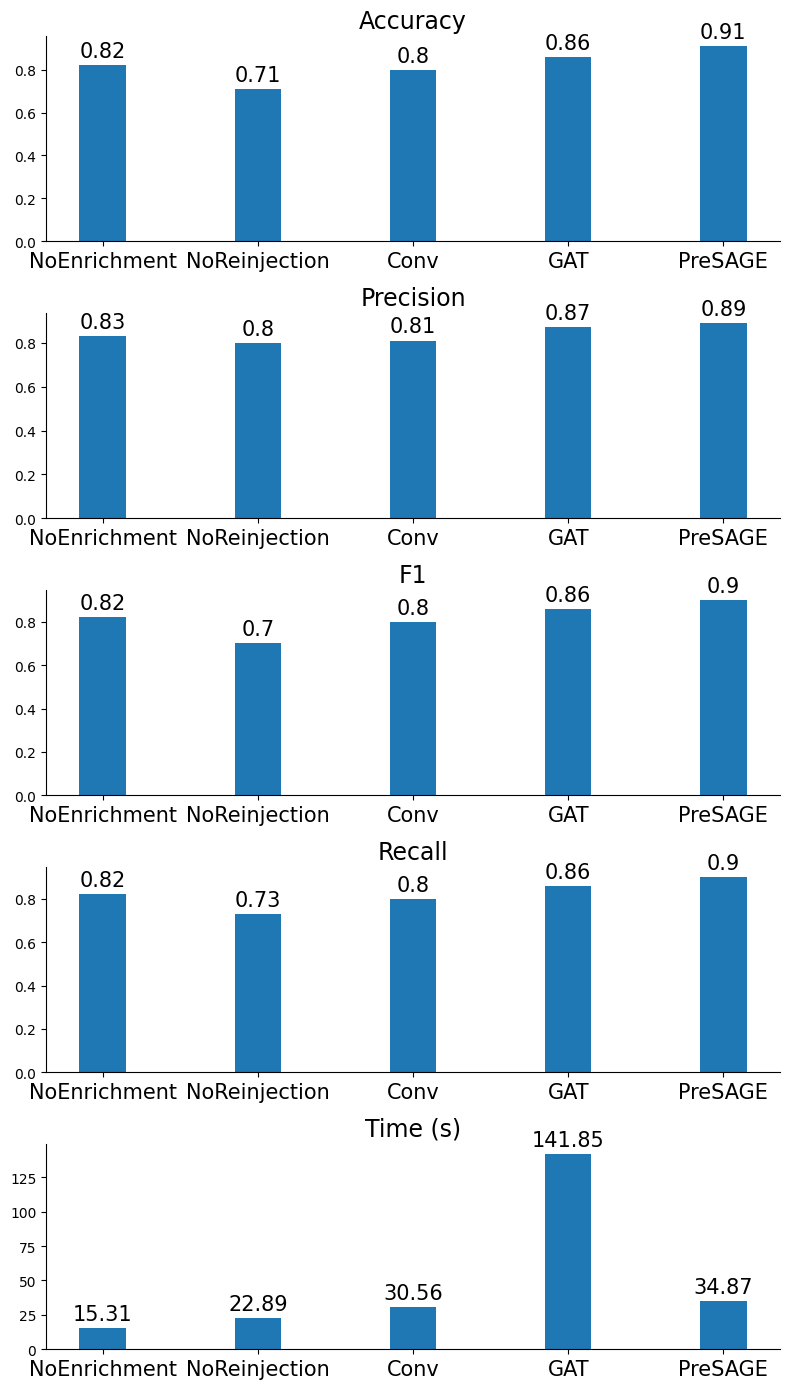

In [245]:
import matplotlib.pyplot as plt

x = np.arange(len(models))

# Plotting the bar plots
width = 0.3  # width of the bars
fig, axs = plt.subplots(5, 1, figsize=(8, 14))

rects_accuracy = axs[0].bar(x, accuracy, width, label='Accuracy')
axs[0].set_title('Accuracy', fontsize = 17)
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, fontsize = 15)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].title.set_position([0.5, .05])  # Adjust the position of title for subplot 1

rects_precision = axs[1].bar(x, precision, width, label='Precision')
axs[1].set_title('Precision', fontsize = 17)
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, fontsize = 15)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].title.set_position([0.5, .05])  # Adjust the position of title for subplot 1

rects_f1 = axs[2].bar(x, f1, width, label='F1')
axs[2].set_title('F1', fontsize = 17)
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, fontsize = 15)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].title.set_position([0.5, .05])  # Adjust the position of title for subplot 1

rects_recall = axs[3].bar(x, recall, width, label='Recall')
axs[3].set_title('Recall', fontsize = 17)
axs[3].set_xticks(x)
axs[3].set_xticklabels(models, fontsize = 15)
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].title.set_position([0.5, .05])  # Adjust the position of title for subplot 1

rects_time = axs[4].bar(x, time, width, label='Time')
axs[4].set_title('Time (s)', fontsize = 17)
axs[4].set_xticks(x)
axs[4].set_xticklabels(models, fontsize = 15)
axs[4].spines['top'].set_visible(False)
axs[4].spines['right'].set_visible(False)
axs[4].title.set_position([0.5, .05])  # Adjust the position of title for subplot 1


def autolabel(rects, n):
    for rect in rects:
        height = rect.get_height()
        axs[n].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 15)
        
autolabel(rects_accuracy, 0)
autolabel(rects_precision, 1)
autolabel(rects_f1, 2)
autolabel(rects_recall, 3)
autolabel(rects_time, 4)


plt.tight_layout() 
plt.show()